In [18]:
%%capture
!pip install transformers datasets tabulate

In [19]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset

from tqdm.notebook import tqdm
from transformers import BertTokenizer
torch.cuda.is_available()

True

This is a template of the notebook that you should complete and enrich with your own code.

First cells will be the same than the ones of the lab on text convolution.

# Data loading


In [20]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


In [21]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)


In [22]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x


In [23]:
n_samples = 50000  # the number of training example

# We first shuffle the data !
data_shuffled = dataset.shuffle()

# Select 5000 samples
data_shuffled_sampled = data_shuffled.select(range(n_samples))

# Tokenize the dataset
data_tokenized = data_shuffled_sampled.map(lambda x: preprocessing_fn(x, tokenizer))

# Remove useless columns
data_tokenized = data_tokenized.remove_columns(["review", "sentiment"])

# Split the train and validation
split = data_tokenized.train_test_split(test_size=0.2)
train_set = split['train']
valid_set = split["test"]


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [24]:
from torch.utils.data import Dataset

class sentiment(Dataset):
    def __init__(self, review_label_set):
      self.sentences = review_label_set["review_ids"]
      self.labels = review_label_set["label"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx: int):
        return self.sentences[idx], self.labels[idx]

In [25]:
def collate_fn(batch, max_size = 256):
    sentences_padded = []
    labels = []

    for sentence, label in batch:

        sentence_padded = [0]*max_size
        sentence_padded[:len(sentence)] = sentence
        sentences_padded.append(sentence_padded)
        labels.append(label)

    return {
        'sentences_padded': torch.tensor(sentences_padded, dtype=torch.long),
        'labels': torch.tensor(labels, dtype=torch.long),
    }

In [26]:
train_dataset = sentiment(train_set)
valid_dataset = sentiment(valid_set)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [28]:
batch = next(iter(train_loader))
batch['labels'].shape

torch.Size([32])

# Model

In [52]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim,device = 'cuda'):
        super(Word2Vec, self).__init__()
        self.device = device
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim).to(device)

In [53]:
vocab_size = tokenizer.vocab_size
embedding_dim = 100

In [54]:
class CNNTextClassifier_2(nn.Module):
    def __init__(self,word2vec, vocab_size, embedding_dim,random_embedding = False, num_classes=1, feature_size=100, kernel_size=3):
        super().__init__()

        # Embedding layer
        #self.embedding = word2vec.word_embeddings
        if random_embedding : 
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        else : self.embedding = word2vec.word_embeddings
        self.feature_size = feature_size
        #self.embedding.weight = nn.Parameter(embedding_matrix)
        #self.embedding.weight.requires_grad = learnable_embedding  # Do not train the embedding layer

        # First convolutional block
        self.conv = nn.Conv1d(
            embedding_dim,
            feature_size,
            kernel_size,
            padding=math.floor(kernel_size / 2),
        )

        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(feature_size, 1)
        self.out_activation = nn.Sigmoid()

    def forward(self, x):
        # Embedding: (batch_size, sequence_length, embedding_dim)
        x = self.embedding(x)

        # Permute for Conv1D: (batch_size, embedding_dim, sequence_length)
        x = x.permute(0, 2, 1)

        # Convolutional Block 1: Conv1D + MaxPool
        x = F.relu(self.conv(x))
        x = self.pool(x)

        x = x.squeeze(dim=2)
        x = self.dropout(x)
        logits = self.linear(x)

        return self.out_activation(logits)

In [55]:
model = CNNTextClassifier_2(word2vec,vocab_size, embedding_dim).to('cuda')

In [56]:
def train(model, num_epochs = 20) :
    # Example: Binary cross-entropy loss for binary classification
    criterion = nn.BCELoss()

    # Example: Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Training loop with accuracy tracking

    train_loss_hist = []
    val_loss_hist = []

    train_acc_hist = []
    val_acc_hist = []

    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training phase
        print("## Train",end=" ")
        for batch in tqdm(train_loader):
            texts = batch['sentences_padded'].to('cuda')
            labels = batch['labels'].to('cuda')
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(texts).squeeze(1)  # (batch_size,) after squeezing
            loss = criterion(outputs, labels.float())
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track training loss
            running_loss += loss.item()

            # Compute training accuracy
            preds = (outputs >= 0.5).long()  # Convert probabilities to binary (0 or 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        # Compute training accuracy
        train_accuracy = correct_train / total_train
        train_acc_hist.append(train_accuracy)

        # Validation phase
        model.eval()  # Set model to evaluation mode (no dropout, batchnorm frozen, etc.)
        
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # No need to compute gradients during validation
            print("## Val",end=" ")
            for batch in tqdm(valid_loader):
                
                texts = batch['sentences_padded'].to('cuda')
                labels = batch['labels'].to('cuda')
                outputs = model(texts).squeeze(1)
                loss = criterion(outputs, labels.float())

                # Track validation loss
                val_loss += loss.item()

                # Compute validation accuracy
                preds = (outputs >= 0.5).long()  # Convert probabilities to binary (0 or 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        # Compute validation accuracy
        val_accuracy = correct_val / total_val
        val_acc_hist.append(val_accuracy)

        # Print epoch statistics
        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {running_loss / len(train_loader):.4f}, '
            f'Train Accuracy: {train_accuracy:.4f}, '
            f'Val Loss: {val_loss / len(valid_loader):.4f}, '
            f'Val Accuracy: {val_accuracy:.4f}')
        
    return train_acc_hist,val_acc_hist


In [ ]:
word2vec = Word2Vec(vocab_size,embedding_dim).to('cuda')
word2vec.load_state_dict(torch.load("model2_dim-100_radius-10_ratio-5_batch-1024_epoch-12_samples-50000.ckpt",weights_only=True))
model = CNNTextClassifier_2(word2vec,vocab_size, embedding_dim).to('cuda')
train_acc_hist,val_acc_hist = train(model,40)

In [ ]:
model = CNNTextClassifier_2(word2vec,vocab_size, embedding_dim,random_embedding=True).to('cuda')
train_acc_hist_random,val_acc_hist_random = train(model,40)

In [ ]:
word2vec = Word2Vec(vocab_size,embedding_dim).to('cuda')
word2vec.load_state_dict(torch.load("model2_dim-100_radius-10_ratio-5_batch-1024_epoch-10_samples-10000.ckpt",weights_only=True))
model = CNNTextClassifier_2(word2vec,vocab_size, embedding_dim).to('cuda')
train_acc_hist_low,val_acc_hist_low = train(model,40)

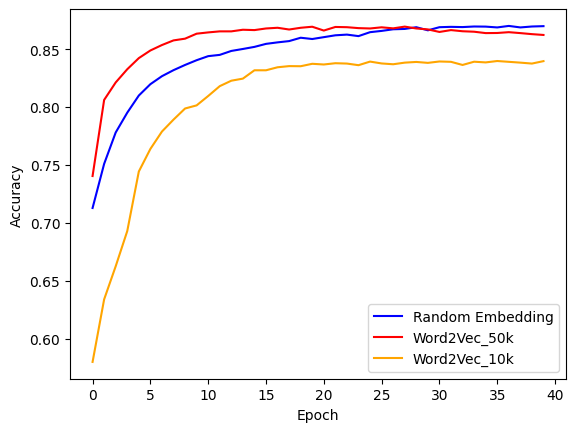

In [71]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(val_acc_hist_random)),val_acc_hist_random,c = 'blue',label="Random Embedding")
plt.plot(np.arange(len(val_acc_hist)),val_acc_hist,c = 'red',label="Word2Vec_50k")
plt.plot(np.arange(len(val_acc_hist_low)),val_acc_hist_low,c = 'orange',label="Word2Vec_10k")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()